# Selector Group Chat
SelectorGroupChat implements a team where participants take turns broadcasting messages to all other members. A generative model (e.g., an LLM) selects the next speaker based on the shared context, enabling dynamic, context-aware collaboration.

Key features include:
- Model-based speaker selection
- Configurable participant roles and descriptions
- Prevention of consecutive turns by the same speaker (optional)
- Customizable selection prompting
- Customizable selection function to override the default model-based selection

SelectorGroupChat is a group chat similar to RoundRobinGroupChat, but with a model-based next speaker selection mechanism. When the team receives a task through run() or run_stream(), the following steps are executed:
1. The team analyzes the current conversation context, including the conversation history and participants’ name and description attributes, to determine the next speaker using a model. You can override the model by providing a custom selection function.
2. The team prompts the selected speaker agent to provide a response, which is then broadcasted to all other participants.
3. The termination condition is checked to determine if the conversation should end, if not, the process repeats from step 1.
4. When the conversation ends, the team returns the TaskResult containing the conversation history from this task.

Once the team finishes the task, the conversation context is kept within the team and all participants, so the next task can continue from the previous conversation context. You can reset the conversation context by calling reset().

## Load Azure Configurations

In [1]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Create Azure OpenAI Client

In [3]:
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

# Create the token provider
#token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")

az_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment=azure_openai_deployment,
    model=azure_openai_deployment,
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    # azure_ad_token_provider=token_provider,  # Optional if you choose key-based authentication.
    api_key=azure_openai_key, # For key-based authentication.
)

from openai import AzureOpenAI

# Create the Dalle client
dalle_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
dalle_deployment_name = "dall-e-3"

# Create the Vision client
vision_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
vision_deployment_name = "gpt-4o"

## Creating the Agents

In [4]:
from typing import Sequence
from autogen_agentchat.agents import AssistantAgent, UserProxyAgent
from autogen_agentchat.conditions import MaxMessageTermination, TextMentionTermination
from autogen_agentchat.messages import AgentEvent, ChatMessage
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.ui import Console
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path


# Define a tool
# This function calls the Dalle-3 image generator given the prompt and displays the generated image.
def generate_image(prompt: str) -> str:
    """
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
    """

    print("Dalle Assistant Message: Creating the image ...")

    response = dalle_client.images.generate(
        model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
    )

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "temp.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: " + full_path)
    return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"

# Define an agent
dalle_assistant = AssistantAgent(
    name="dalle_assistant",
    description="This agent calls the Azure OpenAI Dall-e 3 model to generate an image from a text prompt coming from the user or a vision assistant.",
    model_client=az_model_client,
    tools=[generate_image],
    system_message="""
    As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. 
    It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, 
    prior to delivering a response.
    """,
)

In [5]:
# Analyze the image
def analyze_image() -> str:
    """
    Call the Azure OpenAI Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
    """
    print("Vision Assistant Message: " + "Analyzing the image...")

    import base64
    from pathlib import Path

    # Create a Path object for the image file
    image_path = Path("temp.jpg")

    # Using a context manager to open the file with Path.open()
    with image_path.open("rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    content_images = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
        for base64_image in [base64_image]
    ]
    response = vision_client.chat.completions.create(
        model=vision_deployment_name,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                    },
                    *content_images,
                ],
            }
        ],
        max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

# Creating the vision assistant agent
vision_assistant = AssistantAgent(
    name="vision_assistant",
    description="This agent analyzes and critic an image and return the result. The resulting output should be a new prompt for dalle assistant that enhances the image based on the criticism and analysis",
    model_client=az_model_client,
    tools=[analyze_image],
    system_message="""
    As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. 
    Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision 
    before you provide feedback to the user. You have access to the local file system where the image is stored.
    """,
)

In [6]:
# Create the user proxy agent.
user_proxy = UserProxyAgent("user_proxy", input_func=input)  # Use input() to get user input from console.

In [7]:
# create the planning agent
planning_agent = AssistantAgent(
    "PlanningAgent",
    description="An agent for planning tasks, this agent should be the first to engage when given a new task.",
    model_client=az_model_client,
    system_message=f"""
    You are a planning agent.
    Your job is to break down complex tasks into smaller, manageable subtasks.
    Your team members are:
        Dalle Assistant: An AI specializing in image generation.
        Vision Assistant: An AI expert in image analysis.
        User Proxy: The user

    You will follow this sequence:
        Dalle Assistant will generate an image based on the initial user prompt and display it for review.
        Vision Assistant will analyze the image and provide a new prompt for Dalle Assistant to generate a new image based on the new prompt.
        Dalle Assistant will generate an image based on the Vision Assistant prompt and display it for review.
        Vision Assistant will analyze the image and provide a new prompt for Dalle Assistant to generate a new image based on the new prompt.
        Dalle Assistant will generate an image based on the Vision Assistant prompt and display it for review.
        Vision Assistant will analyze the image and provide a new prompt for Dalle Assistant to generate a new image based on the new prompt.
        User Proxy will provide feedback on process.
        
    You only plan and delegate tasks - you do not execute them yourself.

    When assigning tasks, use this format:
    1. <agent> : <task>
    """,
)

## Creating the team
Let’s create the team with two termination conditions: 
- TextMentionTermination to end the conversation when the User Proxy sends “APPROVE”
- MaxMessageTermination to limit the conversation to avoid infinite loop.

In [8]:
text_mention_termination = TextMentionTermination("APPROVE")
max_messages_termination = MaxMessageTermination(max_messages=50)
termination = text_mention_termination | max_messages_termination

team = SelectorGroupChat(
    [planning_agent, dalle_assistant, vision_assistant, user_proxy],
    model_client=az_model_client,
    termination_condition=termination,
)

## Specify the Task and Run the Team

---------- user ----------
Generate an image of a boat drifting in the water and analyze it and enhance the image


/home/codespace/.python/current/lib/python3.12/site-packages/autogen_agentchat/teams/_group_chat/_selector_group_chat.py:135: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  response = await self._model_client.create(messages=select_speaker_messages)


---------- PlanningAgent ----------
1. Dalle Assistant: Generate an image of a boat drifting in the water and display it for review.
[Prompt tokens: 283, Completion tokens: 23]


/home/codespace/.python/current/lib/python3.12/site-packages/autogen_agentchat/agents/_assistant_agent.py:343: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-05-13. Model mapping may be incorrect.
  result = await self._model_client.create(


---------- dalle_assistant ----------
[FunctionCall(id='call_IfLJO6P8MAXau8DYzu1foda6', arguments='{"prompt":"a boat drifting in the water, peaceful scenery, calm waters, soft lighting"}', name='generate_image')]
[Prompt tokens: 195, Completion tokens: 29]
Dalle Assistant Message: Creating the image ...


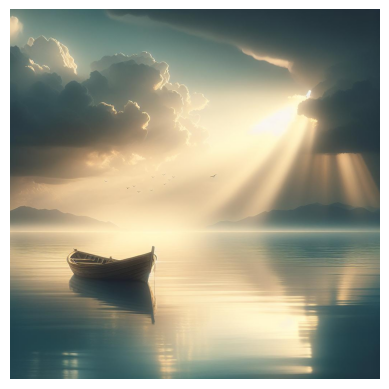

Dalle Assistant Message: /workspaces/AzureAI/AutoGen/temp.jpg
---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_IfLJO6P8MAXau8DYzu1foda6')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- vision_assistant ----------
[FunctionCall(id='call_W31WgQoEUtFcKDHjUdZGaRVi', arguments='{}', name='analyze_image')]
[Prompt tokens: 220, Completion tokens: 12]
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: Analysis and Critique:

This image showcases a beautifully serene scene with a lone boat floating on calm waters, illuminated by a striking beam of light breaking through dense, dramatic clouds. The composition elegantly balances the elements, creating a peaceful and almos

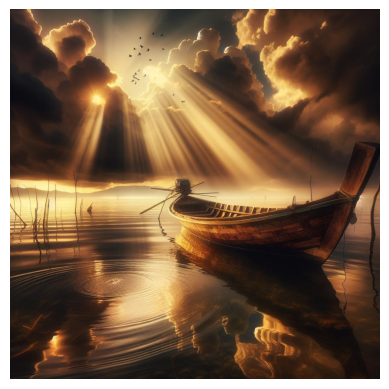

Dalle Assistant Message: /workspaces/AzureAI/AutoGen/temp.jpg
---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_5x79VLbPhOz1OmUyHbZxeOXQ')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- vision_assistant ----------
[FunctionCall(id='call_WcxK0EcddAacwfcFHj8dt3ZE', arguments='{}', name='analyze_image')]
[Prompt tokens: 699, Completion tokens: 12]
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The image of the boat amidst a serene water body and dramatic sky is quite stunning. The rays of sunlight piercing through the clouds, casting reflections on the water, creates an ethereal and nostalgic atmosphere. The composition is strong, leading the eye from the boat t

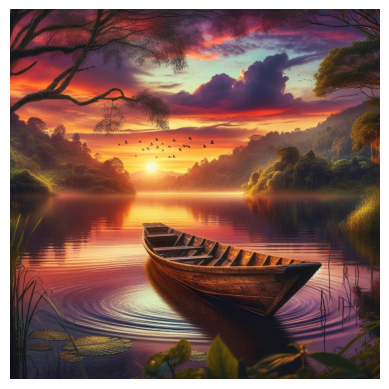

Dalle Assistant Message: /workspaces/AzureAI/AutoGen/temp.jpg
---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_6EshA1bYEYelo2qVJ1k7xfYy')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- vision_assistant ----------
[FunctionCall(id='call_LWYRDqhRjXRHBCDPsrW8eHxl', arguments='{}', name='analyze_image')]
[Prompt tokens: 967, Completion tokens: 12]
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The image portrays a serene and picturesque sunset scene over a tranquil lake with a wooden boat as the central focal point. The sky is adorned with dramatic cloud formations bathed in rich hues of orange, pink, and purple, which reflect beautifully on the water's surface.

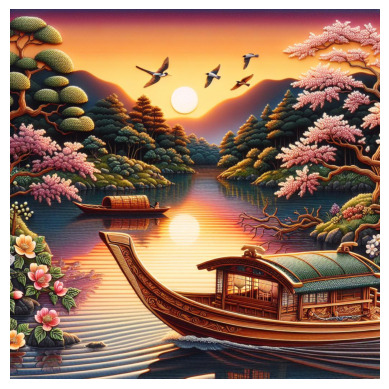

Dalle Assistant Message: /workspaces/AzureAI/AutoGen/temp.jpg
---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_vj4VDygtO96ObeIsXFU5dDOh')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- vision_assistant ----------
[FunctionCall(id='call_jkm5FjtnADm8Okr01xqX40se', arguments='{}', name='analyze_image')]
[Prompt tokens: 1545, Completion tokens: 12]
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The image is a visually stunning, vivid portrayal of a tranquil river scene at sunset, featuring traditional wooden boats, blossoming trees, and birds in flight. The art style is highly detailed and intricate, with a strong emphasis on vibrant colors, especially pinks and

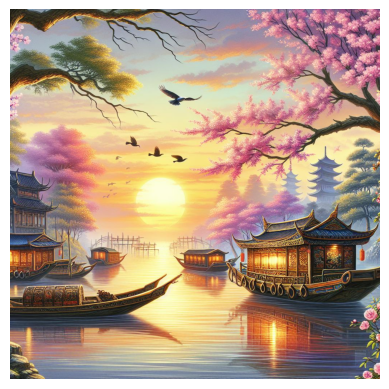

Dalle Assistant Message: /workspaces/AzureAI/AutoGen/temp.jpg
---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_2jF9D26mI68PHb5WxOmKV5P2')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- vision_assistant ----------
[FunctionCall(id='call_7F9El8aiJKBxUa1d32O3gTyZ', arguments='{}', name='analyze_image')]
[Prompt tokens: 2025, Completion tokens: 12]
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: This image evokes a serene and idyllic traditional East Asian riverscape at sunset, adorned with cherry blossoms, intricately designed boats, and pagoda-style structures. The reflective water, warm hues of the sky, and the golden sunlight create a tranquil and harmonious 

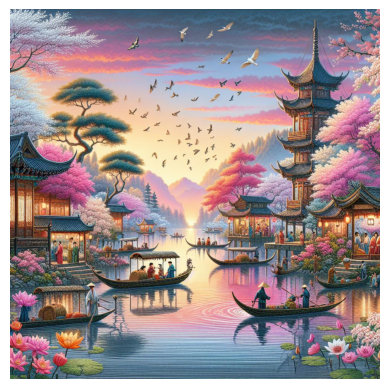

Dalle Assistant Message: /workspaces/AzureAI/AutoGen/temp.jpg
---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_6RvfWszvq38J6skFMSPegpJi')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- vision_assistant ----------
[FunctionCall(id='call_g3bxYJTno9GVjzkBrIOumkCV', arguments='{}', name='analyze_image')]
[Prompt tokens: 2432, Completion tokens: 12]
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: Analysis and Critique:
The given image depicts an enchanting, colorful traditional Asian waterfront village at sunset, encapsulated with elements of beauty and tranquility. The architectural style is characterized by traditional pagodas, vibrant cherry blossom trees, and 

Dalle Assistant Message: Creating the image ...
Dalle Assistant Message: /workspaces/AzureAI/AutoGen/temp.jpg
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The image captures a serene lakeside scene with a picturesque boat and a beautiful interplay of sunlight through the tree branches, resulting in sparkling reflections on the water. The water is crystal clear, revealing an array of smooth stones beneath the surface. The composition is balanced with the branch extending into the water, and the soft rays of sunlight add a magical quality to the scene.

**Critique:**
- Composition: The composition is well-balanced, but the presence of more elements, such as birds or a slight breeze causing ripples on the water, could add dynamism.
- Sunlight Effect: The sparkle effect on the water is enchanting but slightly overpowering; perhaps toning this down could create a more natural feel.
- Clarity: While the water's clarity is impressive, adding a few fish or aquatic

In [9]:
task = "Generate an image of a boat drifting in the water and analyze it and enhance the image"
# Use asyncio.run(...) if you are running this in a script.
response = await Console(team.run_stream(task=task))

## Printing whole response per agent source

In [10]:
# ANSI escape code for bold text
bold_start = "\033[1m"
bold_end = "\033[0m"

# ANSI escape code for red text
red_start = "\033[31m"
red_end = "\033[0m"

for messages in response.messages:
    source = messages.source
    print(f"{bold_start}{red_start}{source}{bold_end}{red_end}")
    print(messages.content)

user
Generate an image of a boat drifting in the water and analyze it and enhance the image
PlanningAgent
1. Dalle Assistant: Generate an image of a boat drifting in the water and display it for review.
dalle_assistant
[FunctionCall(id='call_IfLJO6P8MAXau8DYzu1foda6', arguments='{"prompt":"a boat drifting in the water, peaceful scenery, calm waters, soft lighting"}', name='generate_image')]
dalle_assistant
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_IfLJO6P8MAXau8DYzu1foda6')]
dalle_assistant
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
vision_assistant
[FunctionCall(id='call_W31WgQoEUtFcKDHjUdZGaRVi', arguments='{}', name='analyze_image')]
vision_assistant
[FunctionExecutionResult(content='Analysis and Critique:\n\nThis image showcases a beautifully serene scene w

## Custom Selector Function
Often times we want better control over the selection process. To this end, we can set the selector_func argument with a custom selector function to override the default model-based selection. For instance, we want the Planning Agent to speak immediately after any specialized agent to check the progress.

---------- user ----------
Generate an image of a boat drifting in the water and analyze it and enhance the image
---------- PlanningAgent ----------
1. Dalle Assistant: Generate an image of a boat drifting in the water.
2. Vision Assistant: Analyze the generated image and provide a new prompt for Dalle Assistant to enhance the image.
[Prompt tokens: 283, Completion tokens: 41]
---------- dalle_assistant ----------
[FunctionCall(id='call_YnvKnXDJKfXNTtt2F0kYE94m', arguments='{"prompt": "a boat drifting in the water"}', name='generate_image')]
[Prompt tokens: 213, Completion tokens: 36]


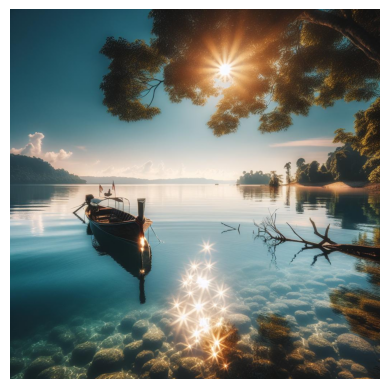

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_YnvKnXDJKfXNTtt2F0kYE94m')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- PlanningAgent ----------
3. Vision Assistant: Analyze the generated image of a boat drifting in the water and provide a new prompt for Dalle Assistant to enhance the image.
[Prompt tokens: 363, Completion tokens: 31]
---------- vision_assistant ----------
[FunctionCall(id='call_PnMF3oCwq3cv7EFsZnqENi0u', arguments='{}', name='analyze_image')]
[Prompt tokens: 275, Completion tokens: 12]
---------- vision_assistant ----------
[FunctionExecutionResult(content="The image captures a serene lakeside scene with a picturesque boat and a beautiful interplay of sunlight thro

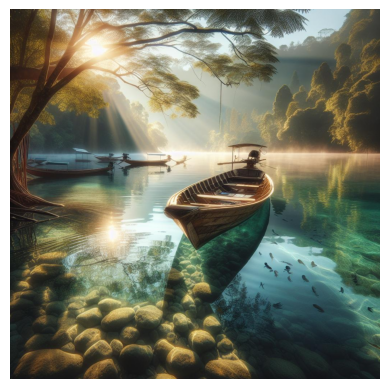

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_S4TeiF4IiiYgCdRyPfpuzivF')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- PlanningAgent ----------
5. Vision Assistant: Analyze the newly generated enhanced image and provide a new prompt for Dalle Assistant to further refine the image.
[Prompt tokens: 852, Completion tokens: 27]
---------- vision_assistant ----------
[FunctionCall(id='call_Cs8pb5RDD1DaAA9N6NUn4ule', arguments='{}', name='analyze_image')]
[Prompt tokens: 776, Completion tokens: 12]
---------- vision_assistant ----------
[FunctionExecutionResult(content='This image portrays a serene and picturesque lakeside scene with a few boats scattered across crystal-clear waters, whi

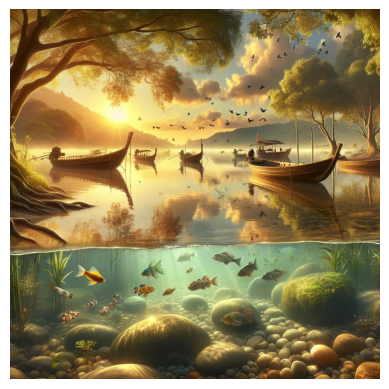

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_q4crwgZ2ztbKd53lBeJRlMDb')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- PlanningAgent ----------
7. Vision Assistant: Analyze the newly generated image and provide a new prompt for Dalle Assistant to further refine the image.
[Prompt tokens: 1500, Completion tokens: 26]
---------- vision_assistant ----------
[FunctionCall(id='call_zDbx4eVm6la1260BX0XX0GJ4', arguments='{}', name='analyze_image')]
[Prompt tokens: 1439, Completion tokens: 12]
---------- vision_assistant ----------
[FunctionExecutionResult(content='The image presented is a blend of serene natural elements, showcasing a bifocal view. The top half features a peaceful lakesid

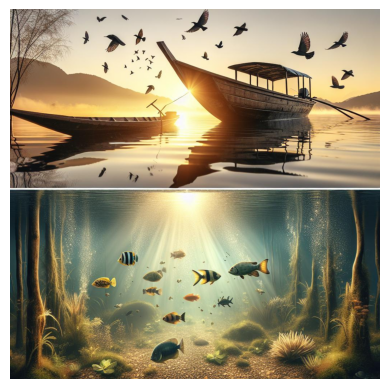

---------- dalle_assistant ----------
[FunctionExecutionResult(content='Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant', call_id='call_yuPXlv5KzItYFaTbkg6gaMK6')]
---------- dalle_assistant ----------
Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant
---------- PlanningAgent ----------
9. Vision Assistant: Analyze the newly generated image and provide feedback. This will help us determine if any further refinements are necessary or if the image is complete.
[Prompt tokens: 2138, Completion tokens: 34]
---------- vision_assistant ----------
[FunctionCall(id='call_HsFX68RZU9BAPaJZ4mu2cC2k', arguments='{}', name='analyze_image')]
[Prompt tokens: 2101, Completion tokens: 12]
---------- vision_assistant ----------
[FunctionExecutionResult(content='The image is divided into two distinct scenes: the upper half depicts a beautifu

In [11]:
# This function determines whether the last message in the sequence was sent by the planning_agent. 
# If it wasn't, the function returns the name of the planning_agent; otherwise, it returns None.
# Returning None from the custom selector function will use the default model-based selection.
def selector_func(messages: Sequence[AgentEvent | ChatMessage]) -> str | None:
    if messages[-1].source != planning_agent.name:
        return planning_agent.name
    return None


# Reset the previous team and run the chat again with the selector function.
await team.reset()

team = SelectorGroupChat(
    [planning_agent, dalle_assistant, vision_assistant, user_proxy],
    model_client=az_model_client,
    termination_condition=termination,
    selector_func=selector_func,
)

response = await Console(team.run_stream(task=task))

In [ ]:
for messages in response.messages:
    source = messages.source
    print(f"{bold_start}{red_start}{source}{bold_end}{red_end}")
    print(messages.content)